# HHL Algorithm

#### Code  Adopted from " Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts" - Hector Jose Morrell Jr, Anika Zaman, and Hiu Yung Wong, https://arxiv.org/abs/2108.09004

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from qiskit_aer import Aer
from copy import deepcopy
import numpy as np

In [2]:
# Create the Quantum and Classical registers needed
clock = QuantumRegister(2, name='clock')
b_vec = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, b_vec, measurement)

circuit.barrier()
#circuit.draw(output='mpl')
circuit.draw()

░ 
ancilla: ─░─
          ░ 
clock_0: ─░─
          ░ 
clock_1: ─░─
          ░ 
      b: ─░─
          ░ 
    c: 2/═══

In [3]:
def hhl(circ, ancilla, clock, b_vec, measurement):
    qpe(circ, clock, b_vec)

    circuit.barrier()
    #conditional Rotation
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()

    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, b_vec)

In [4]:
def qft_dagger(circ, q, n):
    circ.h(clock[1]);
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cp(-np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
        for k in reversed(range(j+1,n)):
            circ.cp(np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [5]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], b_vec, label='U');

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], b_vec, label='U2');

    circuit.barrier();

    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)

def inv_qpe(circ, clock, target):

    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], b_vec, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], b_vec, label='U');

    circuit.barrier()

In [6]:
# State preparation.
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, b_vec, measurement)

# Perform a Hadamard Transform
circuit.h(clock)
circuit.barrier()
circuit.measure(b_vec, measurement[1])

In [7]:
circuit.draw(scale=1)

░                     ░       ░                         »
ancilla: ─░─────────────────────░───────░─────────────────────────»
          ░                     ░ ┌───┐ ░            U            »
clock_0: ─░─────────────────────░─┤ H ├─░────────────■────────────»
          ░                     ░ ├───┤ ░            │            »
clock_1: ─░─────────────────────░─┤ H ├─░────────────┼────────────»
          ░ ┌─────────────────┐ ░ └───┘ ░ ┌──────────┴───────────┐»
      b: ─░─┤ Initialize(0,1) ├─░───────░─┤ U(π/2,-π/2,π/2,3π/4) ├»
          ░ └─────────────────┘ ░       ░ └──────────────────────┘»
    c: 2/═════════════════════════════════════════════════════════»
                                                                  »
«                        ░                         ░ ┌───────┐┌─────────┐ ░ ┌─┐»
«ancilla: ───────────────░─────────────────────────░─┤ Ry(π) ├┤ Ry(π/3) ├─░─┤M├»
«                        ░                ┌───┐    ░ └───┬───┘└────┬────┘ ░ └╥┘»
«clock_0: ───────────────░───────■────────┤ H ├─X──░─────■─────────┼──────░──╫─»
«               U2       ░ ┌───┐ │P(-π/2) └───┘ │  ░               │      ░  ║ »
«clock_1: ──────■────────░─┤ H ├─■──────────────X──░───────────────■──────░──╫─»
«         ┌─────┴──────┐ ░ └───┘                   ░                      ░  ║ »
«      b: ┤ U(π,π,0,0) ├─░─────────────────────────░──────────────────────░──╫─»
«         └────────────┘ ░                         ░                      ░  ║ »
«    c: 2/═══════════════════════════════════════════════════════════════════╩═»
«                                                                            0 »
«          ░                        ░                                        »
«ancilla: ─░────────────────────────░────────────────────────────────────────»
«          ░    ┌───┐               ░                           U            »
«clock_0: ─░──X─┤ H ├─■─────────────░───────────────────────────■────────────»
«          ░  │ └───┘ │P(π/2) ┌───┐ ░       U2                  │            »
«clock_1: ─░──X───────■───────┤ H ├─░───────■───────────────────┼────────────»
«          ░                  └───┘ ░ ┌─────┴──────┐┌───────────┴───────────┐»
«      b: ─░────────────────────────░─┤ U(π,π,0,0) ├┤ U(π/2,π/2,-π/2,-3π/4) ├»
«          ░                        ░ └────────────┘└───────────────────────┘»
«    c: 2/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«          ░       ░    
«ancilla: ─░───────░────
«          ░ ┌───┐ ░    
«clock_0: ─░─┤ H ├─░────
«          ░ ├───┤ ░    
«clock_1: ─░─┤ H ├─░────
«          ░ └───┘ ░ ┌─┐
«      b: ─░───────░─┤M├
«          ░       ░ └╥┘
«    c: 2/════════════╩═
«                     1

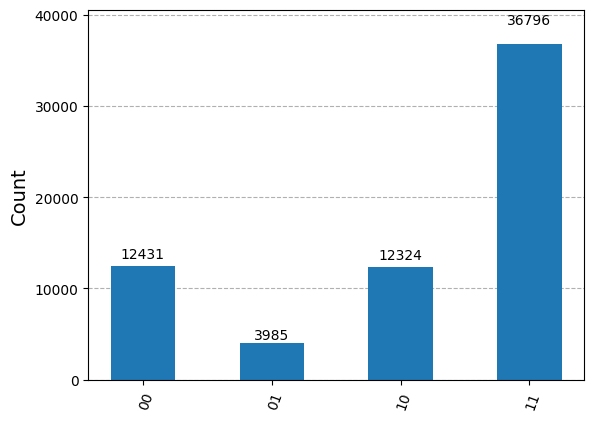

In [9]:
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(transpile(circuit, simulator), shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# Display the results
plot_histogram(counts)